# Single-page Crop Cloud

In [ ]:
# This was developed and run soley in Google Colab

In [ ]:
# import and install everything
from zipfile import ZipFile
import random
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow  # for displaying images in Colab

# install tesseract
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
tess_binary = !which tesseract  # Find out where the pytesseract execution file resides
pytesseract.pytesseract.tesseract_cmd = tess_binary[0]

image shape = (960, 720, 3)


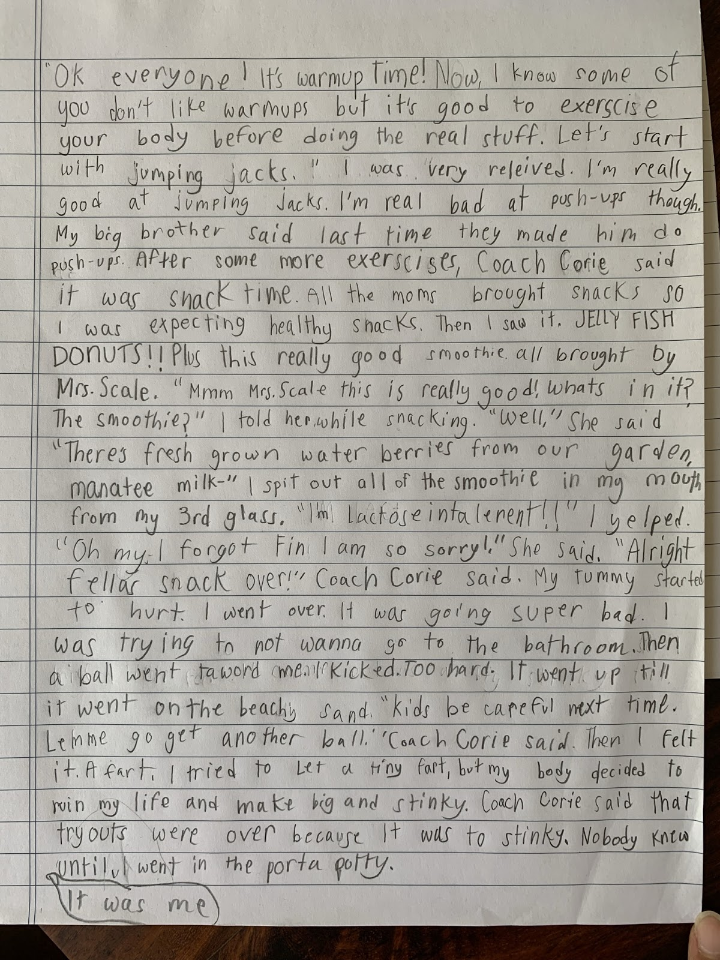

In [2]:
# resize so the longest side is max_length
def load_image(filename, max_length=None):
    image = cv2.imread(filename)
    if max_length:
      original_length = max( image.shape[:2] )
      scale_factor = max_length / original_length
      image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    return image
original = load_image("temsy's story.jpg", 960)  # resize to 1920 long
print(f'image shape = {original.shape}')
cv2_imshow(original)

In [ ]:
# convert to black and white
def make_monochrome(image, block_size, c, blur):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    block_size = 31  # for smoothing out a varying exposure. too small etches out text. must be an odd number > 1
    c = 13  # denoising. too small and you have noise, too big erodes text
    image = cv2.adaptiveThreshold(
        src=image,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=block_size,
        C=c)
    if blur > 1:
        image = cv2.GaussianBlur(image, (blur, blur), 0)
    return image
mono = make_monochrome(original, block_size=21, c=7, blur=1)
print(f'image shape = {mono.shape}')
cv2_imshow(mono)

In [ ]:
%%time
# get the bounding boxes for all words
import pandas as pd

boxes = pytesseract.image_to_data(mono, output_type='dict')
boxes = pd.DataFrame(boxes)
boxes['conf'] = pd.to_numeric(boxes['conf'], errors='ignore')
display(boxes.sample(10))

# visualize the segmented words on a page by drawing the bounding boxes
def markup(page, boxes):
    for row in boxes.to_dict('records'):
        left = row['left'] # 224
        top = row['top'] # 132
        width = row['width'] # 234
        height = row['height'] # 50
        conf = row['conf'] / 100 # 52 / 100
        max = 255
        green = max * conf
        red = max * (1 - conf)
        color = (0, green, red)
        page = cv2.rectangle(page, (left, top), (left+width, top+height), color, 2)
    return page
cv2_imshow(markup(original.copy(), boxes))

left  top  width  height  conf               text  complexity
281   348  501    175      26     0  Lachaceinfaleneat         6.0
9     112   66    117      24    25           everyony         4.0
442   592  759     53      25    64            decided         3.0
508    56  853    124      29     0         ntilykwent         3.0
127   347  249    113      29    73        exerscigts,         3.0
..    ...  ...    ...     ...   ...                ...         ...
256   421  472     24      18    89                the         0.2
143   347  282     27      21    91                the         0.2
50    377  127     26      18    94                the         0.2
360   467  635     31      20    93                the         0.2
510   226  856     26      18    87                the         0.2

[210 rows x 7 columns]

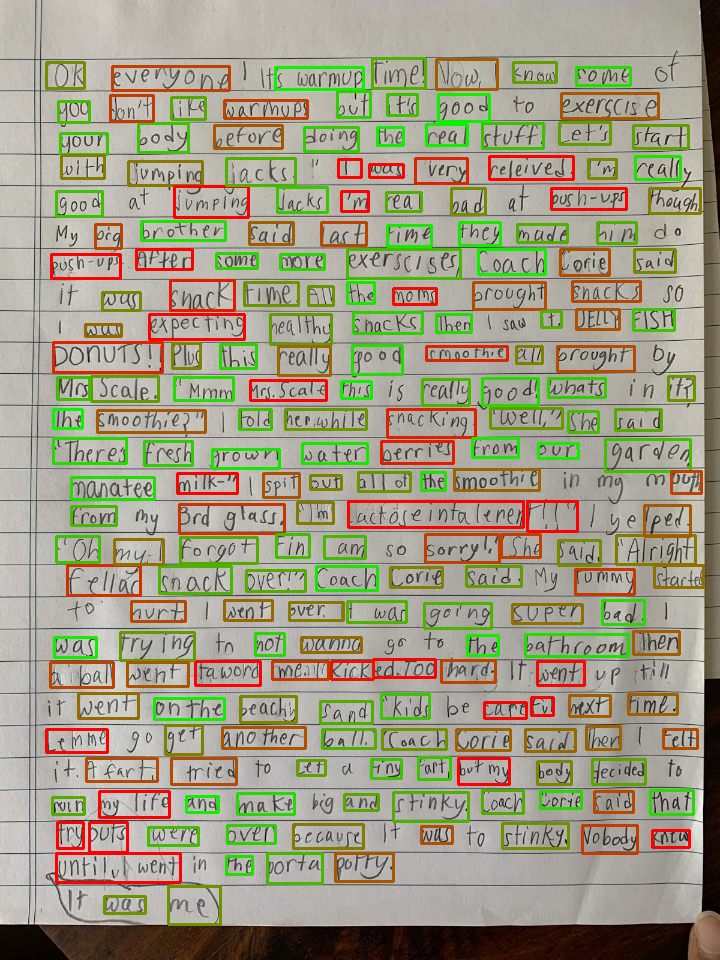

In [15]:
# let's clean this up
boxes = boxes[ (boxes['text'].str.contains('[A-Za-z]')) & (boxes['text'].str.len() > 2)]
boxes.drop(columns=['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num'], inplace=True, errors='ignore')
display(boxes)
cv2_imshow(markup(original.copy(), boxes))

In [10]:
def get_complexity(words, metric='len_count'):
    # https://medium.com/@mholtzscher/programmatically-counting-syllables-ca760435fab4
    def count_syllables(word):
        word = word.lower()
        syllable_count = 0
        vowels = 'aeiouy'
        if len(word) == 0:
          return 0
        if word[0] in vowels:
            syllable_count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                syllable_count += 1
        if word.endswith('e'):
            syllable_count -= 1
        if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
            syllable_count += 1
        if syllable_count == 0:
            syllable_count = 1
        return syllable_count

    metrics = ['len', 'syl', 'len_count', 'syl_count']
    if metric == 'len':
        words['complexity'] = words['text'].apply(len)

    elif metric == 'syl':
        words['complexity'] = words['text'].apply(count_syllables)

    elif metric == 'len_count':
        length = words['text'].apply(len)
        count = words.groupby('text')['text'].transform('size')
        words['complexity'] = length / count

    elif metric == 'syl_count':
        syl = words['text'].apply(count_syllables)
        count = words.groupby('text')['text'].transform('size')
        words['complexity'] = syl / count
    
    else:
        raise ValueError(f"metric must be one of {['len', 'syl', 'len_count', 'syl_count']} but got '{metric}'")

    # scale the complexities so the sum is 1000
    # words['complexity'] = words['complexity'] / words['complexity'].sum()
    return words['complexity']

boxes['complexity'] = get_complexity(boxes, metric='syl_count')
boxes = boxes.sort_values(by='complexity', ascending=False)
boxes

left  top  width  height  conf               text  complexity
281   348  501    175      26     0  Lachaceinfaleneat         6.0
9     112   66    117      24    25           everyony         4.0
442   592  759     53      25    64            decided         3.0
508    56  853    124      29     0         ntilykwent         3.0
127   347  249    113      29    73        exerscigts,         3.0
..    ...  ...    ...     ...   ...                ...         ...
256   421  472     24      18    89                the         0.2
143   347  282     27      21    91                the         0.2
50    377  127     26      18    94                the         0.2
360   467  635     31      20    93                the         0.2
510   226  856     26      18    87                the         0.2

[210 rows x 7 columns]

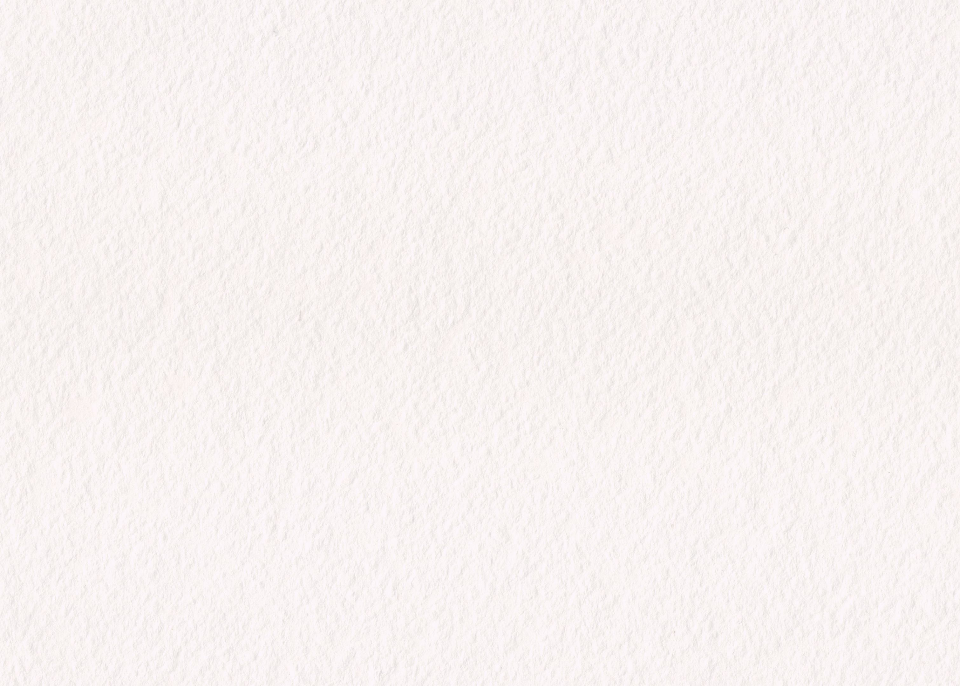

In [14]:
# Load the canvas
canvas = load_image('cream_paper.jpg', 960)  # resize to 1920 long
cv2_imshow(canvas)

In [9]:
# Get the master scale needed to hit a certain density
from math import sqrt

def get_scale(canvas_area, boxes, density):
    desired_area = canvas_area * density
    complexity_word_area = sum(boxes.width * boxes.height * boxes.complexity**2)
    scale = sqrt(desired_area / complexity_word_area)

    print(f'canvas area = {canvas_area:,d}')
    native_word_area = sum(boxes.width * boxes.height)
    print(f'native word area = {native_word_area:,d}')
    print(f'words scaled by complexity = {complexity_word_area:,.0f}')
    print(f'desired area = {desired_area:,.0f}')
    scaled_word_area = sum(boxes.width * boxes.height * boxes.complexity**2 * scale**2)
    print(f'resulting density = {scaled_word_area/canvas_area:.2f}')
    print(f'scale = {scale:.3f}')

    return scale

height, width, _ = canvas.shape
canvas_area = width * height
master_scale = get_scale(canvas_area, boxes, density=0.40)

canvas area = 658,560
native word area = 259,689
words scaled by complexity = 819,545
desired area = 263,424
resulting density = 0.40
scale = 0.567


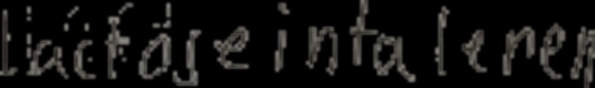

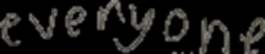

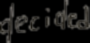

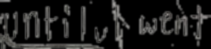

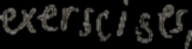

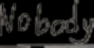

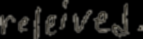

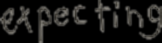

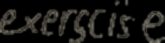

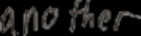

In [12]:
# crop the words out of the page and return them as a list of images in the same order as boxes
def get_clips(page, mono, boxes, master_scale, blur):
  clips = []
  masks = []
  for row in boxes.to_dict('records'):
    left = row['left'] # 224
    top = row['top'] # 132
    width = row['width'] # 234
    height = row['height'] # 50
    scale = row['complexity'] * master_scale
    clip = page[top:top+height, left:left+width]  # crop out the pencil

    clip = cv2.resize(clip, None, fx=scale, fy=scale)
    clips.append(clip)

    mask = mono[top:top+height, left:left+width]  # crop out the mask
    mask = cv2.resize(mask, None, fx=scale, fy=scale)
    mask = cv2.GaussianBlur(mask, (blur, blur), 0)
    mask = np.atleast_3d(mask)
    mask = 1 - (mask / 255)
    masks.append(mask)
  return clips, masks

clips, masks = get_clips(original.copy(), mono.copy(), boxes, master_scale, blur=3)

for clip, mask in zip(clips[:10], masks[:10]):
  dst = clip * mask
  cv2_imshow(dst)

placed 204/210 words
there were 333 total collisions
word area = 249,902, canvas area = 658,560
bounding box density =  0.38
occupied density = 0.19


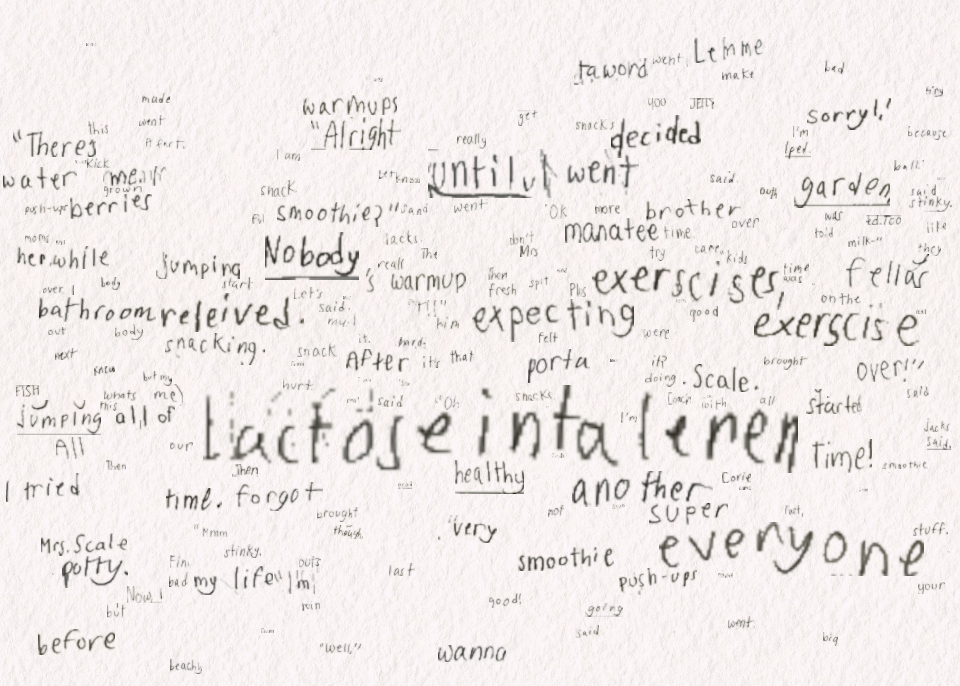

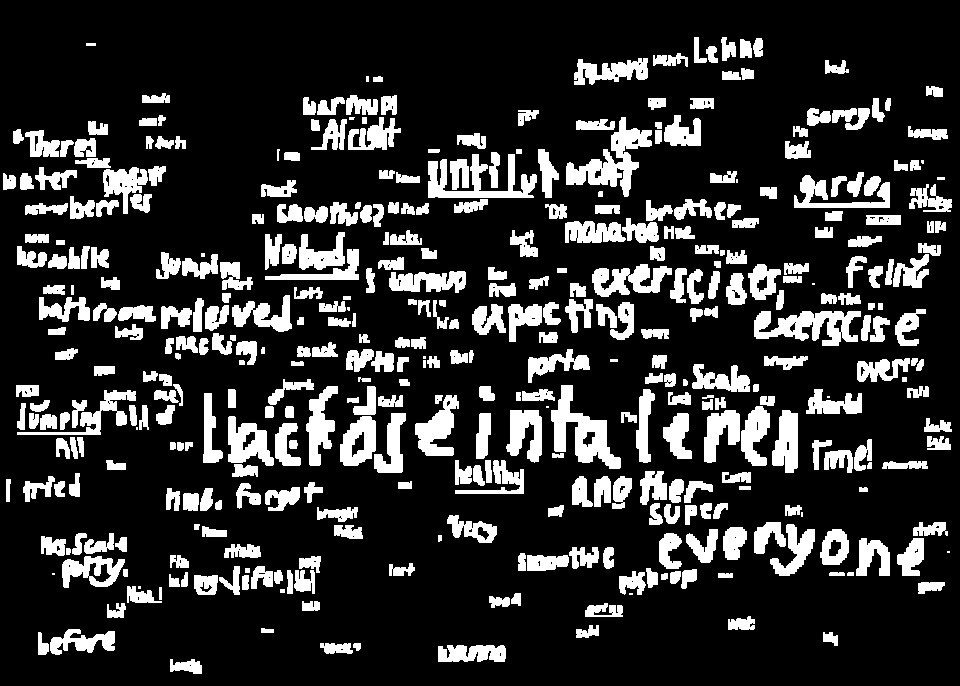

In [13]:
# Finally construct the crop cloud

def pick_x(canvas_width, word_width):
    x_float = np.random.uniform()
    available_room = canvas_width - word_width
    return int(x_float * available_room)

def pick_y(canvas_height, word_height):
    y_float = np.random.triangular(0, 0.5, 1)
    available_room = canvas_height - word_height
    return int(y_float * available_room)

def make_crop_cloud(canvas, boxes, clips, masks):
    occupied = np.zeros(shape=(canvas.shape[:2]), dtype=bool)
    placed = 0
    collisions = 0
    total = len(clips)
    word_area = 0
    for clip, mask in zip(clips, masks):

      max_attempts = 10
      attempts = 0
      while attempts < max_attempts:
          # propose a location for the word
          # does this location collide with anything already placed?
          # if not, then place the word
          # OpenCV uses [y:x] coordinates for images

          # pick a horizontal position
          x1 = pick_x(canvas_width=canvas.shape[1], word_width=clip.shape[1])
          x2 = x1 + clip.shape[1]

          # pick a vertical position
          y1 = pick_y(canvas_height=canvas.shape[0], word_height=clip.shape[0])
          y2 = y1 + clip.shape[0]

          mask_bool = mask.reshape(mask.shape[:2]).astype('bool')
          intersection = np.logical_and(mask_bool, occupied[y1:y2, x1:x2])

          if intersection.sum() > 0:
              # reject this placement
              attempts += 1
              collisions += 1
              continue
          else:
              # place the word
              canvas[y1:y2, x1:x2] = (mask * clip + (1-mask) * canvas[y1:y2, x1:x2])
              occupied[y1:y2, x1:x2] = np.logical_or(mask_bool, occupied[y1:y2, x1:x2])
              word_area += (x2-x1) * (y2-y1)
              placed += 1
              break

    print(f'placed {placed}/{total} words')
    print(f'there were {collisions} total collisions')
    canvas_area = canvas.shape[0] * canvas.shape[1]
    print(f'word area = {word_area:,d}, canvas area = {canvas_area:,d}')
    print(f'bounding box density =  {word_area/canvas_area:.2f}')
    print(f'occupied density = {occupied.sum() / canvas_area:.2f}')

    cv2_imshow(canvas)
    cv2_imshow(occupied*255)

make_crop_cloud(canvas.copy(), boxes, clips, masks)

# Multi-page Crop Cloud

In [ ]:
# import and install everything
from zipfile import ZipFile
import base64
import json
from math import sqrt
import random
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow  # for displaying images in Colab

# install tesseract
!sudo apt install tesseract-ocr
!pip install pytesseract
import pytesseract
tess_binary = !which tesseract  # Find out where the pytesseract execution file resides
pytesseract.pytesseract.tesseract_cmd = tess_binary[0]

## Functions

In [2]:
# All the general functions I'm using for all approaches

# Load the filenames inside a given zip file
def get_filenames(zip_filename):
    with ZipFile(zip_filename, 'r') as zip_file:
        files_in_zip = zip_file.filelist
    for i, fileinfo in enumerate(files_in_zip):
        files_in_zip[i] = fileinfo.filename
    return files_in_zip
# Working with Zip Files  https://www.geeksforgeeks.org/working-zip-files-python/

# Create a random database for all the story images
def create_random_database(db_filename):
    import datetime
    import re

    def get_random_name():
        return random.choice(["Chickpea","Holmes","XiChi","YoungBlood","PenDragon","Frogurt"])

    def get_random_date():
        start_date = datetime.datetime(2015, 1, 1, 0, 0, 0)
        end_date = datetime.datetime(2021, 12, 31, 23, 59, 59)
        total_seconds = (end_date - start_date).total_seconds()

        random_seconds = random.randrange(total_seconds)
        random_date = start_date + datetime.timedelta(seconds=random_seconds)
        return random_date

    page_filenames = get_filenames(zip_filename="./data/story_images.zip")

    names = []
    dates = []
    for filename in page_filenames:
        names.append(get_random_name())
        dates.append(get_random_date())
        # match = re.search("Photo (\d{4})",filename)
        # if match:
        #     pass
        #     # print(match[1])
        #     story_id = match[1]
        #     transcripts.append(transcript)
        # else:
        #     print(f"can't find {filename}'s story_id")

    user_stories = pd.DataFrame({
        'username':names,
        'submission_datetime':dates,
        'image_url':page_filenames,
    })
    user_stories.to_csv(open(db_filename,'w'), index=False)
    user_stories.head()

# Resize so the longest side is max_length
def load_image(filename, max_length=None):
    image = cv2.imread(filename)
    if max_length:
      original_length = max( image.shape[:2] )
      scale_factor = max_length / original_length
      image = cv2.resize(image, None, fx=scale_factor, fy=scale_factor)
    return image

# Convert the image into black and white, separating the text from the background
def make_monochrome(image, blur=1, block_size=31, c=13):
    # blur must be an odd number >= 1
    # block_size is for smoothing out a varying exposure. too small etches out text. must be an odd number > 1
    # c is for denoising. too small and you have noise. too big erodes text.
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    image = cv2.adaptiveThreshold(
        src=image,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY,
        blockSize=block_size,
        C=c)
    if blur > 1:
        image = cv2.GaussianBlur(image, (blur, blur), 0)
    return image

# Test preprocessing on page 3
def test_exposure():
    stories_archive = "./data/story_images.zip"
    page_filenames = get_filenames(stories_archive)
    with ZipFile(stories_archive, 'r') as zip_file:
        page_filename = page_filenames[2]
        raw_data = zip_file.read(page_filename)
        original = cv2.imdecode(np.frombuffer(raw_data, np.uint8), 1)
        mono = make_monochrome(original, block_size=30, c=11, blur=3)  # convert to black and white
        print(page_filename)
        cv2_imshow(mono)

# visualize the segmented words on a page by drawing the bounding boxes
def markup(page, boxes):
    for row in boxes.to_dict('records'):
        left = row['left'] # 224
        top = row['top'] # 132
        width = row['width'] # 234
        height = row['height'] # 50
        conf = row['conf'] / 100 # 52 / 100
        max = 255
        green = max * conf
        red = max * (1 - conf)
        color = (0, green, red)
        page = cv2.rectangle(page, (left, top), (left+width, top+height), color, 2)
    return page

def get_complexity(words, metric='len_count'):
    # https://medium.com/@mholtzscher/programmatically-counting-syllables-ca760435fab4
    def count_syllables(word):
        word = word.lower()
        syllable_count = 0
        vowels = 'aeiouy'
        if len(word) == 0:
          return 0
        if word[0] in vowels:
            syllable_count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                syllable_count += 1
        if word.endswith('e'):
            syllable_count -= 1
        if word.endswith('le') and len(word) > 2 and word[-3] not in vowels:
            syllable_count += 1
        if syllable_count == 0:
            syllable_count = 1
        return syllable_count

    metrics = ['len', 'syl', 'len_count', 'syl_count']
    if metric == 'len':
        words['complexity'] = words['text'].apply(len)

    elif metric == 'syl':
        words['complexity'] = words['text'].apply(count_syllables)

    elif metric == 'len_count':
        length = words['text'].apply(len)
        count = words.groupby('text')['text'].transform('size')
        words['complexity'] = length / count

    elif metric == 'syl_count':
        syl = words['text'].apply(count_syllables)
        count = words.groupby('text')['text'].transform('size')
        words['complexity'] = syl / count
    
    else:
        raise ValueError(f"metric must be one of {['len', 'syl', 'len_count', 'syl_count']} but got '{metric}'")

    # scale the complexities so the sum is 1000
    # words['complexity'] = words['complexity'] / words['complexity'].sum()
    return words['complexity']

# Compute the master scale needed to hit a certain density
def get_scale(boxes, canvas_area, density):
    desired_area = canvas_area * density
    complexity_word_area = sum(boxes.width * boxes.height * boxes.complexity**2)
    scale = sqrt(desired_area / complexity_word_area)

    # print(f'canvas area = {canvas_area:,d}')
    # native_word_area = sum(boxes.width * boxes.height)
    # print(f'native word area = {native_word_area:,d}')
    # print(f'words scaled by complexity = {complexity_word_area:,.0f}')
    # print(f'desired area = {desired_area:,.0f}')
    # scaled_word_area = sum(boxes.width * boxes.height * boxes.complexity**2 * scale**2)
    # print(f'resulting density = {scaled_word_area/canvas_area:.2f}')
    # print(f'scale = {scale:.3f}')
    return scale

# Crop the words out of the page and return them as a list of images in RGBA format
def get_clips(page, mono, boxes, blur=3):
    clips = []
    for row in boxes.to_dict('records'):
        left = row['left'] # 224
        top = row['top'] # 132
        width = row['width'] # 234
        height = row['height'] # 50b_channel, g_channel, r_channel = cv2.split(img)
        BGR = page[top:top+height, left:left+width]  # crop the color image
        B, G, R = cv2.split(BGR)
        A = mono[top:top+height, left:left+width]  # crop out the mask
        A = cv2.GaussianBlur(A, (blur, blur), 0)
        A = 255 - A
        BGRA = cv2.merge((B, G, R, A))
        clips.append(BGRA)
    return clips

# Resizes the cropped words for a given canvas area and density
def scale_clips(boxes, canvas_area, density=0.40):
    master_scale = get_scale(boxes, canvas_area, density=0.40)
    
    scaled_clips = []
    for row in boxes.to_dict('records'):
        image_scale = master_scale * row['complexity']
        image = row['image']
        new_y = int(image.shape[0] * image_scale)
        new_x = int(image.shape[1] * image_scale)
        if new_x < 3 or new_y < 3:
            scaled_clips.append(None)
            continue
        new_size = (new_x, new_y)

        if image_scale < 1:
            resize_algo = cv2.INTER_AREA  # recommended for shrinking
        else:
            resize_algo = cv2.INTER_CUBIC  # recommended for enlarging
        image = cv2.resize(image, dsize=new_size, interpolation=resize_algo)
        scaled_clips.append(image)
    return scaled_clips
    
# Converts an image to base64 for a given image format
def img_to_base64(image, format='.png'):
    retval, buffer = cv2.imencode(format, image)
    b64_bytes = base64.b64encode(buffer)
    b64_string = b64_bytes.decode()
    return b64_string
    # There are many flags you can use to configure the compression, but they are different for each image format
    # https://docs.opencv.org/4.5.2/d8/d6a/group__imgcodecs__flags.html#ga292d81be8d76901bff7988d18d2b42ac

# Filters the dataframe of whole-page metadata for a given user and date range
# replace this with a SQL query that pulls from a database
def get_pages(user_id, date_range=None):
        pages = pd.read_csv("./data/stories_meta.csv")
        pages["submission_datetime"] = pd.to_datetime(pages["submission_datetime"], infer_datetime_format=True)
        pages = pages[pages["username"] == user_id]
        if date_range is not None:
            start_date, end_date = date_range
            start_date = pd.to_datetime(start_date, infer_datetime_format=True)
            end_date = pd.to_datetime(end_date, infer_datetime_format=True)
            end_date += pd.DateOffset(1)  # so this whole day is included
            
            pages = pages[pages["submission_datetime"] >= start_date]
            pages = pages[pages["submission_datetime"] <= end_date]
        return pages  # a subset of the pages metadata database

# Creates a table of metadata for the words on a page (without adding cropped words to the table)
# This is the slow step, taking 3-5 seconds per page
# One idea is to put this step in the submission pipeline, and cache this page_data
# It may also be possible to speed up this method through multi-threading
# Or through 
def parse_page(page_uri):
    # open zip, read in one image
    stories_archive = "./data/story_images.zip"
    with ZipFile(stories_archive, 'r') as zip_file:
        # load and prep image
        raw_data = zip_file.read(page_uri)
    original = cv2.imdecode(np.frombuffer(raw_data, np.uint8), 1)
    mono = make_monochrome(original, block_size=31, c=13, blur=1)  # convert to black and white

    # get and process the bounding boxes of words
    page_data = pytesseract.image_to_data(mono, output_type='dict')  # segment image
    page_data = pd.DataFrame(page_data)
    page_data['conf'] = pd.to_numeric(page_data['conf'], errors='ignore')
    page_data = page_data[ (page_data['text'].str.contains('[A-Za-z]')) & (page_data['text'].str.len() > 2)]
    page_data = page_data[(page_data['width'] / page_data['height']) > 1]
    page_data.drop(columns=['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num'], inplace=True)
    return page_data

# Return a filename without the file extention
def get_root_filename(full_filename):
    filename_parts = full_filename.split('.')
    root_filename = filename_parts[:-1]  # lose the file extention
    root_filename = '.'.join(root_filename)
    return root_filename

# Check the metadata files and regenerate any missing ones
# This is a stand-in until a proper SQL database is created
# This method is untested and will probably need debugging
# Additionally, assemble_page_data() should be refactored to load the metadata that this generates
def fill_metadata_holes():
    page_metadata_file = "./data/page_metadata.zip"
    page_metas = get_filenames(zip_filename = page_metadata_file)
    page_metas = [get_root_filename(page_meta) for page_meta in page_metas]

    page_uris = get_filenames(zip_filename = "./data/story_images.zip")
    all_metadata = []
    for page_uri in page_uris:
        root_uri = get_root_filename(page_uri)
        csv_name = root_uri + '.csv'
        if root_uri not in page_metas:
            page_data = parse_page(page_uri)
        else:
            with ZipFile(page_metadata_file, 'r') as zip_file:
                buffer = zip_file.read(page_uri)
            page_data = pd.read_csv(buffer)
        metadata.append((csv_name, page_data))

    with zipfile.ZipFile(page_metadata_file, 'w') as zip_session:        
        for csv_name, page_data in all_metadata:
            # convert page_data to a csv buffer
            page_buffer = page_data.to_csv(index=False)

            # write the csv buffer to the file under the filename
            zip_session.writestr(csv_name, page_buffer, compress_type=zipfile.ZIP_DEFLATED)

# Creates a word table for a single page, including the file path, date, and cropped words
# Right now this re-parses all pages from scratch, which is slow
# Refactor to pull saved metadata generated by fill_metadata_holes()
def assemble_page_data(page_specs):
    page_uri = page_specs["image_url"]
    page_data = parse_page(page_uri)
    
    # add the filename and date for this page, repeated on every row
    page_data['page_uri'] = page_uri
    page_data['date'] = page_specs["submission_datetime"]

    # add the cropped words
    with ZipFile("./data/story_images.zip", 'r') as zip_file:
        # load and prep image
        raw_data = zip_file.read(page_uri)
        original = cv2.imdecode(np.frombuffer(raw_data, np.uint8), 1)
        mono = make_monochrome(original, blur=1)  # convert to black and white
    page_data['image'] = get_clips(original, mono, page_data, blur=1)

    return page_data

# Collate all the requested pages into one words table, including the file path, date, and cropped words
def get_user_words(user_id, date_range=None, complexity_metric="len_count"):
    pages_data = get_pages(user_id=user_id, date_range=date_range)
    if date_range is not None:
        if len(pages_data) == 1:
            plural = f'is {len(pages_data)} page'
        else:
            plural = f'are {len(pages_data)} pages'
        print(f'There {plural} for {user_id} between {date_range[0]} and {date_range[1]}')

    # load all pages and images into one table
    user_words = pd.DataFrame()
    for page_specs in pages_data.to_dict('records'):
        # returns a table of words with cropped images in RGBA format
        page_data = assemble_page_data(page_specs)
        user_words = pd.concat([user_words,page_data])
    user_words.drop(columns=['left', 'top', 'conf'], inplace=True)

    # add complexity
    user_words["complexity"] = get_complexity(user_words, metric=complexity_metric)
    user_words.sort_values(by='complexity', ascending=False, inplace=True)
    return user_words

# Picks a random horizontal location for a cropped word
# This is the heart of arranging the words chronologically
def pick_x(canvas_width, word_width, date_number=None, total_dates=None):
    if total_dates:  # this is untested and may need to be debugged
        # for now, this divides the space into even fractions
        # I had wanted to use arc cosine waves to give a fuzzy distribution, but never finished the function bending
        x_float = np.random.uniform(
            low=date_number/total_dates,
            high=(date_number+1)/total_dates,
            )
    else:
        x_float = np.random.uniform()
    available_room = canvas_width - word_width
    return int(x_float * available_room)

# Picks a random vertical location for a cropped word
# This uses a triangular distribution which biases the words towards the midline, where your eyes will start
def pick_y(canvas_height, word_height):
    y_float = np.random.triangular(0, 0.5, 1)
    available_room = canvas_height - word_height
    return int(y_float * available_room)

# Constructs and renders a crop cloud. Returns an image
def make_crop_cloud(canvas, boxes):
    # propose a location for the word
    # does this location collide with anything already placed?
    # if not, then place the word
    # OpenCV uses [y:x] coordinates for images

    occupied = np.zeros(shape=(canvas.shape[:2]), dtype=bool)
    placed = 0
    collisions = 0
    total = len(boxes)
    word_area = 0
    for row in boxes.to_dict('records'):
        image = row['image']

        max_attempts = 20
        failed_attempts = 0
        while failed_attempts < max_attempts:
            # pick a horizontal position
            x1 = pick_x(
                canvas_width=canvas.shape[1],
                word_width=image.shape[1],
                date_number=0,
                total_dates=1,
                )
            x2 = x1 + image.shape[1]

            # pick a vertical position
            y1 = pick_y(canvas_height=canvas.shape[0], word_height=image.shape[0])
            y2 = y1 + image.shape[0]

            R, G, B, mask = cv2.split(image)  # split the image into channels
            color = cv2.merge((B, G, R))
            mask = np.atleast_3d(mask) / 255

            mask_bool = mask.reshape(mask.shape[:2]).astype('bool')
            intersection = np.logical_and(mask_bool, occupied[y1:y2, x1:x2])

            if intersection.sum() > 0:
                # reject this placement
                failed_attempts += 1
                collisions += 1
                continue
            else:
                # place the word
                canvas[y1:y2, x1:x2] = (mask * color + (1-mask) * canvas[y1:y2, x1:x2])
                occupied[y1:y2, x1:x2] = np.logical_or(mask_bool, occupied[y1:y2, x1:x2])
                word_area += (x2-x1) * (y2-y1)
                placed += 1
                break

    # print(f'placed {placed}/{total} words')
    # print(f'there were {collisions} total collisions')
    # canvas_area = canvas.shape[0] * canvas.shape[1]
    # print(f'bounding box density =  {word_area/canvas_area:.2f}')
    # print(f'occupied density = {occupied.sum() / canvas_area:.2f}')

    # cv2_imshow(canvas)
    # cv2_imshow(occupied*255)
    return canvas



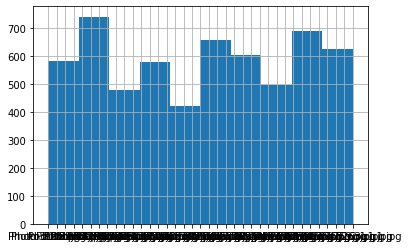

In [ ]:
# A historgram of the number of detected words in the 167 stories
# The actual words per page was perhaps 200 and highly variable
# user_words.filename.hist()

## Dates

In [56]:
# Map the dates to integers. returns a dictionary
def map_dates(user_words):
    dates = sorted(user_words.date.unique())
    D = len(dates)
    date_map = dict()
    for i, date in enumerate(dates):
        date = pd.to_datetime(date)
        date_map[date] = i
    return date_map

# Test the date map
user_words = get_user_words(user_id="XiChi", date_range=("2019-10-23", "2021-10-23"))
date_map = map_dates(user_words)
D = len(date_map)
for date in user_words.date[:5]:
  d = date_map[date]
  print(f'date={date}; date_id={d}; total_dates={D}; float={d/D}')

There are 3 pages for XiChi between 2019-10-23 and 2021-10-23
date=2020-11-14 19:31:27; date_id=2; total_dates=3; float=0.6666666666666666
date=2020-10-01 17:19:19; date_id=0; total_dates=3; float=0.0
date=2020-11-14 19:31:27; date_id=2; total_dates=3; float=0.6666666666666666
date=2020-11-14 19:31:27; date_id=2; total_dates=3; float=0.6666666666666666
date=2020-10-01 17:19:19; date_id=0; total_dates=3; float=0.0


## Base64

In [ ]:
# Base64 stuff
import cv2
import base64
import io
from imageio import imread
# import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = 0
for row in word_data.to_dict('records'):
    img = row["image_base64"]
    text = row["text"]
    print(text)
    # cv2_imshow(img)
    break

print(f"base64 size = {len(img):,d}")
# retval, buffer = cv2.imencode('.png', img, [cv2.IMWRITE_PNG_COMPRESSION, 1])
# https://docs.opencv.org/4.5.2/d8/d6a/group__imgcodecs__flags.html#ga292d81be8d76901bff7988d18d2b42ac

# retval, buffer = cv2.imencode('.webp', img, [cv2.IMWRITE_WEBP_QUALITY, 80])
retval, buffer = cv2.imencode('.webp', img)
b64_bytes = base64.b64encode(buffer)
b64_string = b64_bytes.decode()

# print(f"base64 size = {len(b64_string):,d}")
print(f"{quality:3} = {len(b64_string):5,d} bytes")
# print(b64_string)


# # reconstruct image as an numpy array
# b64_decoded = base64.b64decode(b64_string)
# buffer = io.BytesIO(b64_decoded)
# reimg = imread(buffer, format=".webp")
# cv2_imshow(reimg)
# print(f"shape = {reimg.shape}")

# ==========
# print(buffer)
# reimg = cv2.imdecode(buffer, cv2.IMREAD_ANYCOLOR)

# finally convert RGB image to BGR for opencv
# reimg = cv2.cvtColor(reimg, cv2.COLOR_RGB2BGR)

# nparr = np.fromstring(b64_bytes.decode('base64'), np.uint8)
# reimg = cv2.imdecode(nparr, cv2.IMREAD_ANYCOLOR)

# def readb64(base64_string):
#     sbuf = StringIO()
#     sbuf.write(base64.b64decode(base64_string))
#     pimg = Image.open(sbuf)
#     return cv2.cvtColor(np.array(pimg), cv2.COLOR_RGB2BGR)


# format = '.webp'
# original = load_image("40% dense.png")
# retval, buffer = cv2.imencode(format, original)
# # https://docs.opencv.org/4.5.2/d8/d6a/group__imgcodecs__flags.html#ga292d81be8d76901bff7988d18d2b42ac
# b64_bytes = base64.b64encode(buffer)
# b64_string = b64_bytes.decode()
# with open("crop_cloud.base64", mode='w') as file:
#   file.write(b64_string)

# cvimg = readb64('R0lGODlhEAAQAMQAAORHHOVSKudfOulrSOp3WOyDZu6QdvCchPGolfO0o/XBs/fNwfjZ0frl3/zy7////wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACH5BAkAABAALAAAAAAQABAAAAVVICSOZGlCQAosJ6mu7fiyZeKqNKToQGDsM8hBADgUXoGAiqhSvp5QAnQKGIgUhwFUYLCVDFCrKUE1lBavAViFIDlTImbKC5Gm2hB0SlBCBMQiB0UjIQA7')
# cv2_imshow(cvimg)

# write a random word image to a png.base64 file
with open("png.base64", mode='w') as file:
  row = user_words.sample(1)
  b64_string = row["image_base64"].to_list()[0]
  text = row["text"].to_list()[0]
  print(f"text = {text}; bytes = {len(b64_string):,d}")
  file.write(b64_string)


In [73]:
# Generate a new random stories database
create_random_database("./data/stories_db.csv")

## GET viz/cropped_words

In [3]:
%time
# Scaled Multipage Word Data
def get_cropped_words(user_id, date_range=None, complexity_metric="len_count", format=".webp", canvas_area=960*686, density=0.40):
    """
    Produces a table of cropped words for all pages belonging to the given user over a date range

        Input:
            `user_id` str - a string containing the username
            `date_range` list - a list of two dates in the format of YYYY-MM-DD
            `complexity_metric` str - how to calculate the complexity of words (from 'len', 'syl', 'len_count', 'syl_count')
            `format` str - the format of the cropped word images (from 'png', 'webp', or anything OpenCSV supports)

        Output: JSON(CSV(TABLE([width, height, text, page_uri, date, complexity, image_base64])))
    """
    user_words = get_user_words(user_id, date_range, complexity_metric)

    # scale the word images
    user_words['image'] = scale_clips(user_words, canvas_area, density)
    # images which would be smaller than 3 pixels in either direction are set to None
    user_words = user_words[user_words.image.notnull()]

    # convert images to base64
    user_words['image_base64'] = user_words['image'].apply(img_to_base64, format=format)
    user_words.drop(columns=['image'], inplace=True)

    display(user_words)

    # package into json
    words_csv = user_words.to_csv(index=False)
    words_json = json.dumps(words_csv)
    return words_json

# Usage
words_json = get_cropped_words(
    user_id="XiChi",
    date_range=("2020-10-23", "2020-10-23"),
    complexity_metric="len",
    format=".webp",
    canvas_area=960*686,
    density=0.40,
    )
print(f"words_json is {len(words_json)/1024:,.0f} KB")

# XiChi's page dates:
# 2015-09-29 06:46:39
# 2016-02-15 11:01:07
# 2016-07-21 17:09:43
# 2017-04-02 00:57:37
# 2017-04-10 20:44:35
# 2017-07-03 11:18:34
# 2017-08-09 04:45:18
# 2018-02-01 00:00:06
# 2019-03-04 03:01:14
# 2019-04-10 04:44:16
# 2019-06-16 10:00:55
# 2020-10-01 17:19:19
# 2020-10-23 16:33:27
# 2020-11-14 19:31:27

## Save the json to a sample response
# with open("cropped_words.json", mode='w') as file:
#   file.write(words_json)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
There is 1 page for XiChi between 2020-10-23 and 2020-10-23


width  ...                                       image_base64
193    107  ...  UklGRtoZAABXRUJQVlA4TM0ZAAAv0oAKEE2gbds2kDta/f...
44      14  ...  UklGRjIEAABXRUJQVlA4TCUEAAAvGgAGEPVIzv5/bZusWW...
135     70  ...  UklGRiAQAABXRUJQVlA4TBQQAAAveAAOEE0wattIkNJvwp...
227     61  ...  UklGRlAMAABXRUJQVlA4TEQMAAAvaMAIEE2gbds2kDta/z...
150     63  ...  UklGRpYPAABXRUJQVlA4TIkPAAAvbIANEE2gbds2kNFN+v...
..     ...  ...                                                ...
205     27  ...  UklGRrIBAABXRUJQVlA4TKYBAAAvE0ACECfjsG0bSZKSuS...
206     54  ...  UklGRoYDAABXRUJQVlA4THoDAAAvJwADEI8HoY0kSVJk1j...
209    237  ...  UklGRiIJAABXRUJQVlA4TBYJAAAvrsAGEE0wattIkJJvw5...
133     35  ...  UklGRgYDAABXRUJQVlA4TPkCAAAvGAAEEJcGoY0kSVJkVk...
308     62  ...  UklGRpAFAABXRUJQVlA4TIMFAAAvLEAIEE2YadtGvhv+jD...

[142 rows x 7 columns]

words_json is 296 KB


## GET viz/crop_cloud

There are 11 pages for XiChi between 2015-10-01 and 2020-10-01


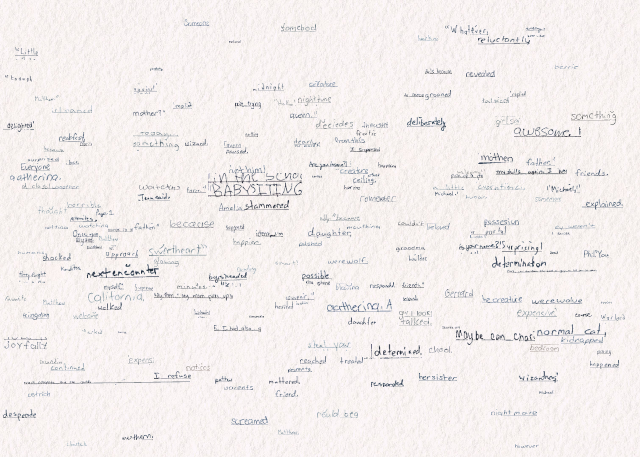

crop_cloud_json is 382 KB


In [53]:
# Renders and returns a whole crop cloud for a user's submissions over a given date range
def get_crop_cloud(user_id, date_range=None, complexity_metric="len_count", image_format=".webp", width=1024, density=0.40, max_words=None):
    """
    Renders and returns a whole crop cloud for a user's submissions over a given date range

    Input:
        `user_id` str - a string containing the username
        `date_range` List[str] - a list of two dates in the format of YYYY-MM-DD
        `complexity_metric` str - how to calculate the complexity of words (from 'len', 'syl', 'len_count', 'syl_count')
        `image_format` str - the format of the cropped word images (from '.png', '.webp', or anything OpenCV supports)
        `width` int - the width of the crop cloud in pixels
        `density` float - the bounding box area of the cropped words divided by the canvas area
        `max_words` int - the max number of words to include in the cloud

    Output:
        json(image_base64) - a rendered crop cloud as an image
    """

    user_words = get_user_words(user_id, date_range, complexity_metric)

    # load the canvas
    canvas = load_image("./data/cream_paper.jpg", max_length=width)
    canvas_area = canvas.shape[0] * canvas.shape[1]

    # scale the word images
    user_words['image'] = scale_clips(user_words, canvas_area, density)
    # images which would be smaller than 3 pixels wide are set to None
    user_words = user_words[user_words.image.notnull()]

    # display(user_words)
    
    crop_cloud = make_crop_cloud(canvas, user_words[:max_words])
    cv2_imshow(crop_cloud)

    # package into json
    crop_cloud_base64 = img_to_base64(canvas, format=image_format)
    crop_cloud_json = json.dumps(crop_cloud_base64)
    return crop_cloud_json

# Usage
crop_cloud_json = get_crop_cloud(
    user_id="XiChi",
    date_range=("2015-10-01", "2020-10-01"),
    complexity_metric="len",
    image_format=".webp",
    width=640,
    density=0.40,
    max_words=200,
    )
print(f"crop_cloud_json is {len(crop_cloud_json)/1024:,.0f} KB")

In [5]:
crop_cloud_json

'"UklGRvgDCgBXRUJQVlA4TOsDCgAvv0OrAFWLg7aNBCltyp/0zt9TiIgJgEL52NJyFijQlt8ttPwuBOgHfhVoW2iBYAoF+uPfq9CU7+5t+d0vbvJV9WkKpeyU9pMqHwuUN6CblAIzuu3D+wQo0HKU4k7bQikFKFDos80UbSlAn7MEFFpehVLucicAaigQpeB+qhSgdDsKUGhaKJuboKUF4sdyFmhLOQKhbdO2BmpiKAV2bfNpyQTcLBCDAQgNbE6gJTEVcDqltKTNDHdUozoNlICZbgpTTUI1AfAIhKg7IaCJ2wKYmSRugoYCDVCqaGIBCsS5F5ps7raJCm4G1CRpmkL46AstrUmKW7KB2yTZNkjhUF2aJlOFxK0ugHObQMimdT6ldZnGTYAQ2gDhLSqgCtlCU9dum6G0LmAoU3cmAUh6hLjNQMlSXdyibhLdFpiZc5tPsgWeNdumbnObO3XbsmWbami2qUJCzKYxg31X43TbnMkKYBRK4s6QuOSfIdtoEn7rBHD6CHOzwaokCWxLEpxzm+c2afZTkjbgNg2OQMoWUOPHTULoNnenUZMYmvK4DZKou2MSINsSt+nohL0KhFPdkujcNKgBgi6Gu3sxBnRJiEGnSgKJsdAEoC3pdAOI2yZum7okG1kJmtJSgCyAC0S3djdAKNlGkrTsLVAIuGkScCcEysQ84Jm0oJuwUUB1M84EKBRI2kJpTUpV3mTbUqNum2lpo7YthVkKUKBALbgNlcapc7pipkKhLVAgzrJt3QalAG2rzgUoO7MBdJvNBuF2QsvdGHU+amaihQJuFvNUKBTAjbvVzQJVTU1IVaGoh5Y2AKVHKa8Dtk2dbptAy7sNQC1/6sb3crpZoJBQADfBrU/1UQW2yefJTxcnm0UHBVpon5aPvdo+bY3QUmgBWs5yfsJ3A2j5Wt7S8gcUKH22CRTKx/KztBd92qsApQXKUdrnY/0+2/dskyQ5fxL/E02amnS11lprrbXWWm

# TODO

In [ ]:
# DONE:
# review what is already in place in the DS repo
# combine and replicate the tesseract code in the 4 i-python notebooks in the repo
# find some sample data of children's handwriting (took pictures of 94 pages of my kids journals)
# load and display a page
# convert to grayscale
# convert to black and white
# implement adaptive thresholding for pictures with a mixed exposure
# extract the words with pytesseract.image_to_string()
# extract bounding boxes around the words with pytesseract.image_to_data()
# draw a rectangle for the bounding box of one word onto the original image
# draw all bounding boxes onto the image
# convert the prediction confidence score to a number
# color the bounding boxes according to the prediction confidence (red >> green)
# trim out the extra bounding boxes around binderpaper lines
# crop out one word and display it
# solve my problem of Pillow not understanding OpenCV images
# resize the cropped words by the aspect ratio of the box. Wider boxes are more complicated words
# copy/paste one word onto a background of paper  https://note.nkmk.me/en/python-opencv-numpy-alpha-blend-mask/
# copy/paste all words and arrange wherever
# mask the words so their background is transparent, and it looks like pencil straight on the main background
# avoid collision when placing the words
# debug why I'm getting 21% density when I attempted 70% (I should have been using squares and sqrt())
# crowd the big words on the horizon line (using a triangular distribution)
# read in Jo's whole journal (38 pages) and combine in one dataframe
# Tell the stakeholder "This word cloud is based on my daughter's whole journal. It incorporates 38 journal entries made over a 9 month period."
# get the repo running locally
# get viz/cropped_words working again

# TODO:
# Features:
# Database Integration:
  # right now, the crop cloud pulls it's data from images and csv's stored in the repo in zip files
  # put this data in SQL tables in an actual database
  # hook the crop cloud code up to the database
# add a GET usernames endpoint so the frontend can add a drop down for usernames
# add a GET submission_dates endpoint (given a user_id) so the frontend can add date pickers to choose a start/end date (maybe)
# Color:
  # convert the submission dates for a given crop cloud to d = date number (starting at 0) and D = number of dates. 
  # colormap choices https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
  # make a function that converts a float number and the name of a colormap to a color in RGB
  # choose the color for each word based on it's submission date as a float (d/(D-1))
  # put extra blur on the transparency map and layer in a colored blurred halo behind the word
  # add parameters to both crop cloud endpoints: "color_map" and "border_width" so the frontend has artistic control
# Page thumbnails:
  # add page thumbnails in a row across the top of the canvas
  # outline the thumbnails using the same color and border style as the words, so they appear associated
  # submissions that are more than one page should appear as a stack of pages with a single border around the whole stack
# Chronological layout:
  # place words in even fractions just to get something simple working
  # do the math to make the horizontal placement be choosen according to a cosine distribution so the word placements are 
    # loosely connected to which document they came from, and so the overall word density across the canvas is constant
  # put this equation in Desmos to start where I left off
  # \left(1-\frac{\arccos\left(2x-1\right)}{\pi\left(D-1\right)}\right)+\frac{d}{D}
  # https://www.desmos.com/calculator
  # d = date number, D = number of dates. The function should make an arccosine wave that claims a d/D fraction of the vertical interval [0-1]
  # Then pass a uniform random number and d and D into this function and you should get a cosine distribution out
  # place the words according to this fuzzy placement, using d and D to clump the words under their page thumbnails
# under the word cloud draw a timeline (arrow and start and end date (Feb 2021 format)) and make the style look like friendly hand drawn marker

# Robustness, Accuracy and Speed:
# The crop cloud endpoints will currently return a code 500 if you request a date with no documents.
  # This should fail more gracefully. Perhaps return an empty word table or just the canvas image
# Caching word bounding boxes for each page and maybe the cropped words too:
  # debug fill_metadata_holes() so that it caches the bounding box locations of words on each page
  # refactor assemble_page_data() to pull saved bounding box data and page images
  # possibly cache the cropped words in the metadata if the time/space tradeoff looks good
# Preprocessing:
  # add auto-deskewing (rotation < 45 degrees)
  # add auto-orienting the page (rotations of 90 degrees)
  # auto-detect the trapezoid of the page/writing and unwarp that instead of deskewing
  # benchmark and optimize the code. perhaps migrate functions to different libraries.
  # during preprocessing, add standardizing the greyscale histogram to read pencil (they don't allow pen in grade school)
  # do hyperparameter tuning to optimize the accuracy you can get from tesseract without retraining
    # do some reading on optimizing segmentation for OCR
    # bundle the optimized preprocessing steps and parameters into a function (raw image in, ready for OCR image out)
    # give the optimized preprocessing function to the tesseract group
# on tesseract add parameters for which mode, engine, and model to use to improve time and accuracy
# plug in the in house tesseract model when it's better than the out of the box one, and re-optimize the best preprocessing parameters
# Testing:
  # write Unit tests
  # write API tests

In [ ]:
# Look into maybe incorporating imutils to clean up my code
# https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/
# https://pypi.org/project/imutils/

# Also scikit-image
# https://scikit-image.org/
# https://pypi.org/project/scikit-image/

# Histogram Equalization may help expose faint pencil better
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

In [ ]:
# Deskew
# https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/

# from skimage import io as ioski
# from skimage.color import rgb2gray

# image = ioski.imread(image)
# grayscale = rgb2gray(image)

# from deskew import determine_skew
# from skimage.transform import rotate, resize

# angle = determine_skew(image)
# print(angle)

# rotated = rotate(image, angle, resize=True) * 255
# print(type(rotated))
# cv2_imshow(rotated)
# print(f'rotated.shape = {rotated.shape}')
# ioski.imsave("output_deskewed.png", rotated.astype(np.uint8))